In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [2]:
data = pd.read_csv('./data/student-mat.csv')
# print(data.info())
# print(data.describe())

In [3]:
continuous_features = ['studytime', 'failures', 'absences', 'age', 'G1']
categorical_features = []
taget_feature = 'G2'

In [4]:
# Handle outliers
for feature in continuous_features:
    cap_value = data[feature].quantile(0.95)
    data[feature] = np.where(data[feature] > cap_value, cap_value, data[feature])

In [5]:
X = data[continuous_features + categorical_features]
y = data[taget_feature]

In [6]:
# Preprocessing: scaling numerical features, encoding categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), continuous_features),
        ('cat', OneHotEncoder(drop='first'), categorical_features)
    ]
)

# Create a pipeline with Linear Regression
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['studytime', 'failures',
                                                   'absences', 'age', 'G1']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first'),
                                                  [])])),
                ('regressor', LinearRegression())])

In [8]:
y_pred = model_pipeline.predict(X_test)
mse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

Mean Squared Error: 1.473993889325423
R^2 Score: 0.8474156765334057


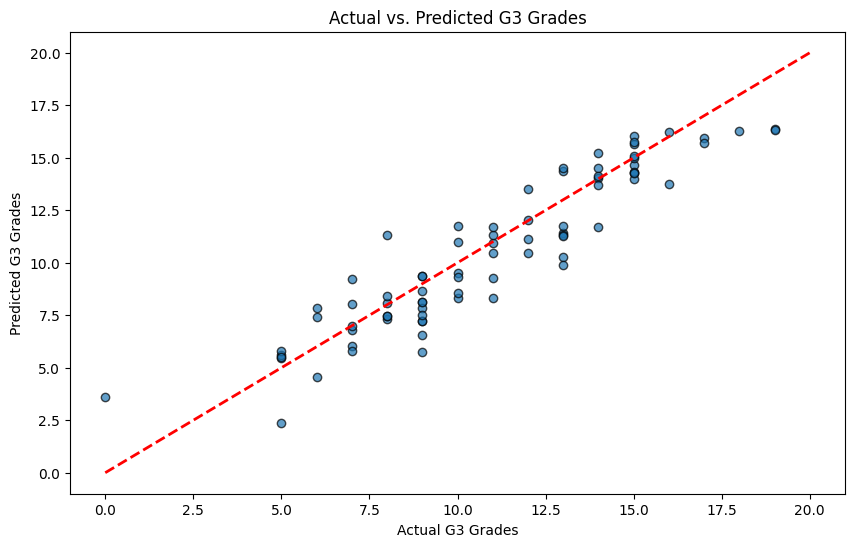

In [9]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.7, edgecolors='k', marker='o')
plt.plot([0, 20], [0, 20], 'r--', lw=2)
plt.xlabel("Actual G3 Grades")
plt.ylabel("Predicted G3 Grades")
plt.title("Actual vs. Predicted G3 Grades")
plt.show()

In [10]:
# Save the model
with open('../webapp/instance/model.pkl', 'wb') as f:
    pickle.dump(model_pipeline, f)

In [11]:
def predict_new_data(studytime, failures, absences, age, G1):
    new_data = pd.DataFrame({
        'studytime': [studytime],
        'failures': [failures],
        'absences': [absences],
        'age': [age],
        'G1': [G1]
    })
    prediction = model_pipeline.predict(new_data)
    print(f"Predicted Final Grade for the input data: {prediction[0]:.2f}")
    return prediction[0]

prediction = predict_new_data(
    studytime=0, 
    failures=0, 
    absences=0, 
    age=19, 
    G1=1
)

Predicted Final Grade for the input data: 0.31
